In [14]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.data.image_rendering_data_module import ImageRenderingDataModule
from imap.model.nerf import NERF
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
from pathlib import Path
import torch
from tqdm.notebook import tqdm
from evo.core.trajectory import PosePath3D

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load images

In [3]:
color_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/1305031464.959763.png"))
depth_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/1305031464.952471.png"))

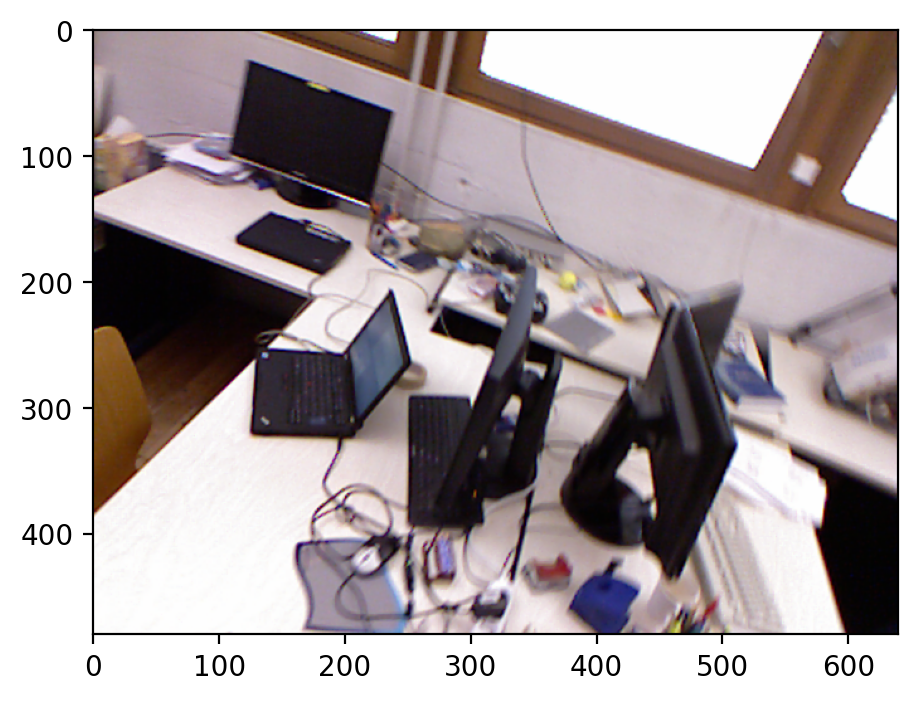

In [4]:
figure = plt.figure(dpi=200)
color_image = cv2.imread(color_image_path)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

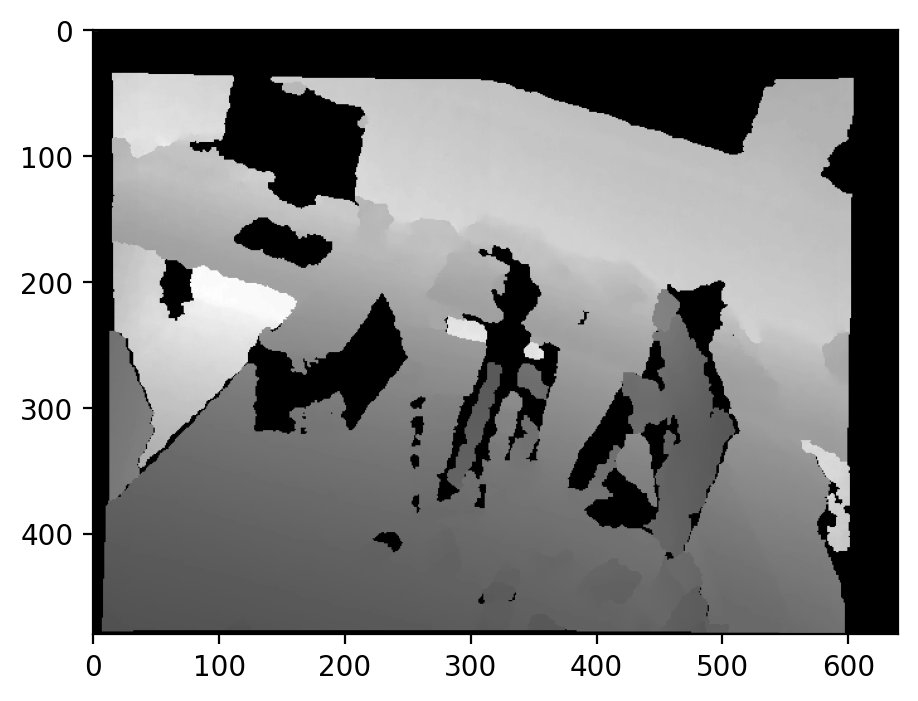

In [5]:
figure = plt.figure(dpi=200)
depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / 5000
depth_image = np.clip(depth_image, 0, 4)
plt.imshow(depth_image, cmap="gray")

In [6]:
dataset_params = {'dataset_path': "/media/mikhail/Data3T/tum_rgbd", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
# dataset_params=1
data_module = ImageRenderingDataModule('tum', **dataset_params)

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt
Read (5, 480, 640, 3) images array
Dataset size: 1536000 pixels
[ToyDataModule] - train subset size 1536000


In [7]:
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(lr=0.005),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    encoding_sigma=25,
    optimize_positions=False,
    minimal_depth=0.01,
)
factory = UniversalFactory([NERF])
model = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())

# Test map builder

In [8]:
from imap.slam.imap_data_loader import IMAPDataLoader
from imap.slam.active_sampler import ActiveSampler
from imap.slam.keyframe_validator import KeyframeValidator
from imap.slam.imap_map_builder import IMAPMapBuilder
from imap.data.tum_frame_loader import TUMFrameLoader
from imap.slam.optimized_frame import OptimizedFrame

In [9]:
dataset_path = "/media/mikhail/Data3T/tum_rgbd"
scene_name = "rgbd_dataset_freiburg1_desk"
association_file_name = "data_association_file.txt"
camera_info = data_module._dataset._camera_info
map_builder_data_loader = IMAPDataLoader(50, 200, camera_info)

sampler_data_loader = IMAPDataLoader(1, 200, camera_info)
sampler = ActiveSampler(sampler_data_loader, 4, 1)

keyframe_validator = KeyframeValidator(0.1, 0.5)
builder = IMAPMapBuilder(model, map_builder_data_loader, sampler, keyframe_validator)
frames = TUMFrameLoader(dataset_path, scene_name, association_file_name, range(0, 500, 1))

initial_position = np.eye(4)[:3, :]
frames = [OptimizedFrame(x, initial_position) for x in frames]

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [10]:
previous_frame = frames[0]
previous_frame.position.requires_grad_(False)
builder.set_current_frame(previous_frame)
builder.step()
for frame in tqdm(frames[1:]):
    frame.position.data = previous_frame.position.detach().clone().requires_grad_(True)
    builder.set_current_frame(frame)
    builder.step()
    previous_frame = frame

Map builder step
Start training
Final loss = 0.7031075358390808
Final image loss = 0.11127792298793793
Keyframe validator criterion = 0.5222222222222223
Keyframe is validated = False


  0%|          | 0/499 [00:00<?, ?it/s]

Map builder step
Start training
Final loss = 0.6691020727157593
Final image loss = 0.11107926815748215
Keyframe validator criterion = 0.563953488372093
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6240110397338867
Final image loss = 0.10327854007482529
Keyframe validator criterion = 0.5180722891566265
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.628777265548706
Final image loss = 0.10500134527683258
Keyframe validator criterion = 0.5857988165680473
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5093989968299866
Final image loss = 0.08423637598752975
Keyframe validator criterion = 0.5947712418300654
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5184114575386047
Final image loss = 0.08336034417152405
Keyframe validator criterion = 0.5260115606936416
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5504732131958008
Final image loss = 0.08

Final loss = 0.45326992869377136
Final image loss = 0.06910838931798935
Keyframe validator criterion = 0.6282051282051282
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.46513471007347107
Final image loss = 0.07301715016365051
Keyframe validator criterion = 0.5471698113207547
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.44756007194519043
Final image loss = 0.07096779346466064
Keyframe validator criterion = 0.6148648648648649
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.44769927859306335
Final image loss = 0.07097389549016953
Keyframe validator criterion = 0.6832298136645962
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4348606467247009
Final image loss = 0.06983304768800735
Keyframe validator criterion = 0.5492957746478874
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4638097882270813
Final image loss = 0.0752660483121872
Keyframe va

Start training
Final loss = 0.4213383197784424
Final image loss = 0.06583056598901749
Keyframe validator criterion = 0.6408450704225352
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.45486247539520264
Final image loss = 0.06785514950752258
Keyframe validator criterion = 0.6335403726708074
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.40027761459350586
Final image loss = 0.06224170699715614
Keyframe validator criterion = 0.6794871794871795
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4188562333583832
Final image loss = 0.06205609813332558
Keyframe validator criterion = 0.6049382716049383
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4307591915130615
Final image loss = 0.06597340852022171
Keyframe validator criterion = 0.6645962732919255
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4265683889389038
Final image loss = 0.065247640013694

Final loss = 0.46687862277030945
Final image loss = 0.07025294005870819
Keyframe validator criterion = 0.4666666666666667
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.4261600375175476
Final image loss = 0.062341004610061646
Keyframe validator criterion = 0.5135135135135135
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4682328402996063
Final image loss = 0.0706825777888298
Keyframe validator criterion = 0.4444444444444444
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5637319087982178
Final image loss = 0.08739595115184784
Keyframe validator criterion = 0.547945205479452
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5451489686965942
Final image loss = 0.08272512257099152
Keyframe validator criterion = 0.5217391304347826
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5755090117454529
Final image loss = 0.09183000028133392
Keyframe validat

Final loss = 0.6909850239753723
Final image loss = 0.11299794912338257
Keyframe validator criterion = 0.5683453237410072
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5694179534912109
Final image loss = 0.08966357260942459
Keyframe validator criterion = 0.610062893081761
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5047368407249451
Final image loss = 0.08197823911905289
Keyframe validator criterion = 0.6102941176470589
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6109431385993958
Final image loss = 0.0973903089761734
Keyframe validator criterion = 0.5205479452054794
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6209601163864136
Final image loss = 0.09954895079135895
Keyframe validator criterion = 0.6506849315068494
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5771780610084534
Final image loss = 0.09341368824243546
Keyframe validat

Final loss = 0.6479830145835876
Final image loss = 0.10774242877960205
Keyframe validator criterion = 0.5538461538461539
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6114450097084045
Final image loss = 0.097426638007164
Keyframe validator criterion = 0.5
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6886914968490601
Final image loss = 0.11632681638002396
Keyframe validator criterion = 0.48344370860927155
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5772501230239868
Final image loss = 0.09236889332532883
Keyframe validator criterion = 0.5547945205479452
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6672653555870056
Final image loss = 0.10715141892433167
Keyframe validator criterion = 0.5547945205479452
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6474024653434753
Final image loss = 0.10453244298696518
Keyframe validator criterion = 

Start training
Final loss = 0.631268322467804
Final image loss = 0.10672793537378311
Keyframe validator criterion = 0.7133333333333334
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5045502781867981
Final image loss = 0.08109299838542938
Keyframe validator criterion = 0.7658227848101266
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5448004007339478
Final image loss = 0.09075342118740082
Keyframe validator criterion = 0.7610062893081762
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5466911196708679
Final image loss = 0.08932638168334961
Keyframe validator criterion = 0.7635135135135135
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6640791296958923
Final image loss = 0.11062339693307877
Keyframe validator criterion = 0.6888888888888889
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6061328053474426
Final image loss = 0.10026591271162033


Final loss = 0.5512179732322693
Final image loss = 0.08314982056617737
Keyframe validator criterion = 0.3841059602649007
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7480604648590088
Final image loss = 0.11950420588254929
Keyframe validator criterion = 0.45454545454545453
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6532554030418396
Final image loss = 0.10331311821937561
Keyframe validator criterion = 0.38848920863309355
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6994080543518066
Final image loss = 0.11334729939699173
Keyframe validator criterion = 0.3356164383561644
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7775425314903259
Final image loss = 0.1256861388683319
Keyframe validator criterion = 0.38323353293413176
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6392134428024292
Final image loss = 0.09724503755569458
Keyframe validato

Start training
Final loss = 0.659471869468689
Final image loss = 0.10391201078891754
Keyframe validator criterion = 0.43790849673202614
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7238404750823975
Final image loss = 0.115003801882267
Keyframe validator criterion = 0.5467625899280576
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.7449360489845276
Final image loss = 0.12414683401584625
Keyframe validator criterion = 0.5222929936305732
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.6769161224365234
Final image loss = 0.10836324095726013
Keyframe validator criterion = 0.4527027027027027
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5983102321624756
Final image loss = 0.09098502993583679
Keyframe validator criterion = 0.4533333333333333
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.8335782289505005
Final image loss = 0.1391432285308838
Keyfr

Final loss = 0.7570874094963074
Final image loss = 0.11746330559253693
Keyframe validator criterion = 0.37662337662337664
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6748944520950317
Final image loss = 0.10480833053588867
Keyframe validator criterion = 0.3783783783783784
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7229965329170227
Final image loss = 0.11522603780031204
Keyframe validator criterion = 0.34375
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7386472821235657
Final image loss = 0.11450576782226562
Keyframe validator criterion = 0.37662337662337664
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7673367261886597
Final image loss = 0.12430264800786972
Keyframe validator criterion = 0.38095238095238093
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7485129833221436
Final image loss = 0.11596700549125671
Keyframe validator criterio

Final loss = 0.6421840786933899
Final image loss = 0.09803478419780731
Keyframe validator criterion = 0.42948717948717946
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7134088277816772
Final image loss = 0.10914476960897446
Keyframe validator criterion = 0.48344370860927155
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7095378041267395
Final image loss = 0.10921020805835724
Keyframe validator criterion = 0.46405228758169936
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7041382193565369
Final image loss = 0.11002033203840256
Keyframe validator criterion = 0.4276729559748428
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.7142308950424194
Final image loss = 0.10936117172241211
Keyframe validator criterion = 0.4397590361445783
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6510418057441711
Final image loss = 0.10756932944059372
Keyframe validat

In [11]:
len(builder._keyframes)

197

In [17]:
import plotly.graph_objects as go
def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.show()



def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

def make_matrix_44_from_34(matrix):
    result = np.zeros((matrix.shape[0], 4, 4))
    result[:, 3, 3] = 1
    result[:, :3, :] = matrix
    return result

In [22]:
ground_truth_trajectory = np.array([x.frame.ground_truth_position for x in frames])
rotation = ground_truth_trajectory[0, :3, :3].copy()
ground_truth_trajectory[:, :3, :3] = rotation.T @ ground_truth_trajectory[:, :3, :3]
ground_truth_trajectory[:, :3, 3:4] = rotation.T @ (
    ground_truth_trajectory[:, :3, 3:4] - ground_truth_trajectory[0, :3, 3:4]) / 10 
predicted_trajectory = np.array([x.matrix_position for x in frames])
evo_ground_truth_path = PosePath3D(poses_se3 = ground_truth_trajectory)
evo_estimated_path = PosePath3D(poses_se3 = make_matrix_44_from_34(predicted_trajectory))
# evo_estimated_path.align(evo_ground_truth_path, False);

In [23]:
show_trajectories(evo_ground_truth_path.positions_xyz, evo_estimated_path.positions_xyz)

In [4]:
np.sqrt(np.mean((evo_ground_truth_path.positions_xyz - evo_estimated_path.positions_xyz) ** 2)) * 1000

NameError: name 'np' is not defined

# Show the results

In [1]:
from scipy.spatial.transform import Rotation

In [2]:
def get_position(translation, rotation):
    matrix_position = np.eye(4)
    matrix_position[:3, 3] = translation
    matrix_position[:3, :3] = Rotation.from_euler("xyz", rotation).as_matrix()
    return matrix_position

In [3]:
scale = 1
y, x = np.meshgrid(range(color_image.shape[0] // scale), range(color_image.shape[1] // scale))                       
pixels = np.array([x, y], dtype=np.float32).T * scale
pixels = torch.tensor(pixels).cuda().reshape(-1, 2)
# position = get_position(np.array([0, 0, 0]), np.array([0, 0, 0]))
# position = data_module._dataset._positions[0]
position = frames[0].matrix_position
# delta_position = get_position(np.array([0, 0, -1]), np.array([0.3, 0, 0]))
delta_position = get_position(np.array([0, 0, -0.1]), np.array([0, 0, 0]))
position = position @ delta_position
positions = torch.repeat_interleave(torch.tensor(position.astype(np.float32))[None], pixels.shape[0],
                                  dim=0).cuda()

NameError: name 'np' is not defined

In [40]:
batch_size = 4096
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []
# model = model.cuda()
model.eval()
with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = model(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/75 [00:00<?, ?it/s]

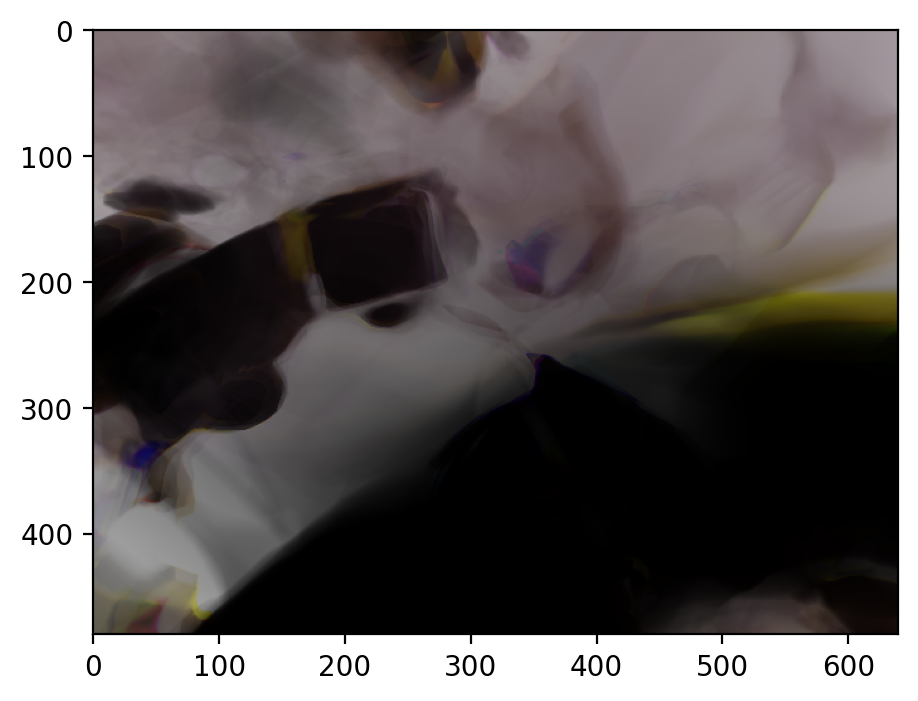

In [41]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

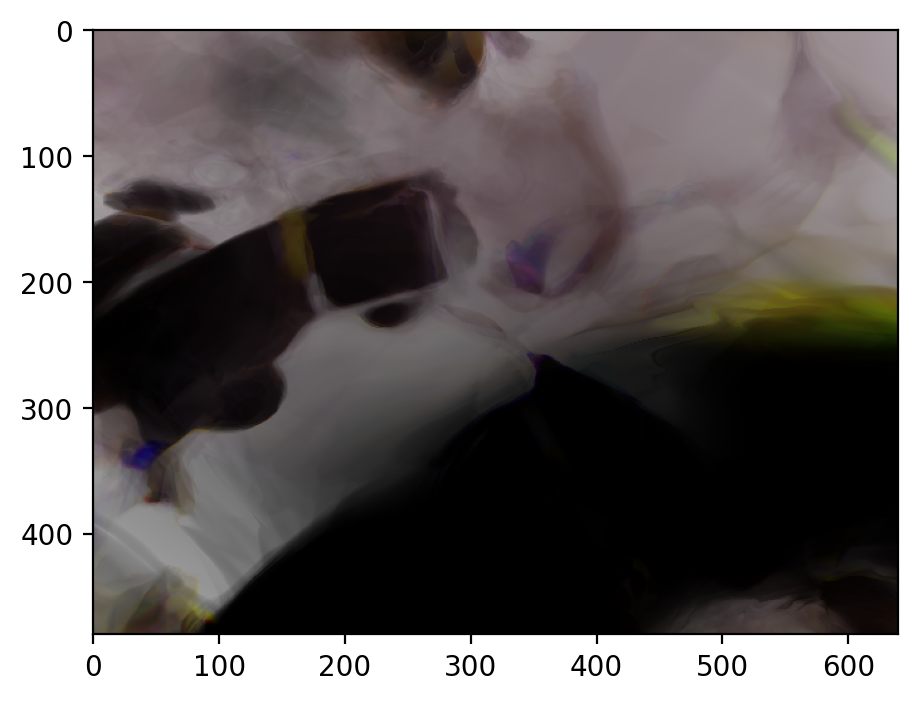

In [42]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

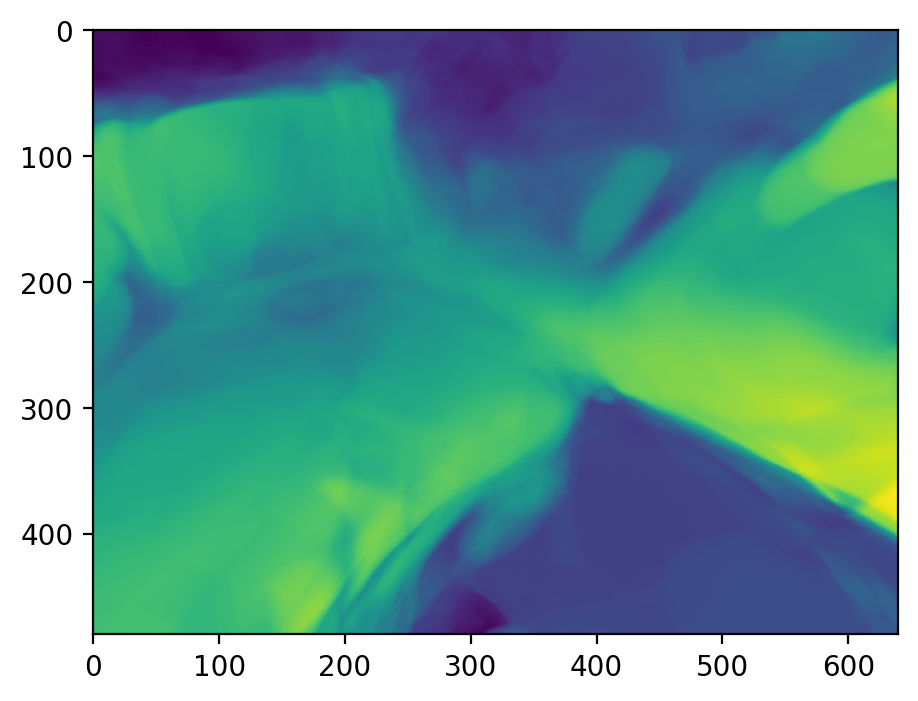

In [30]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

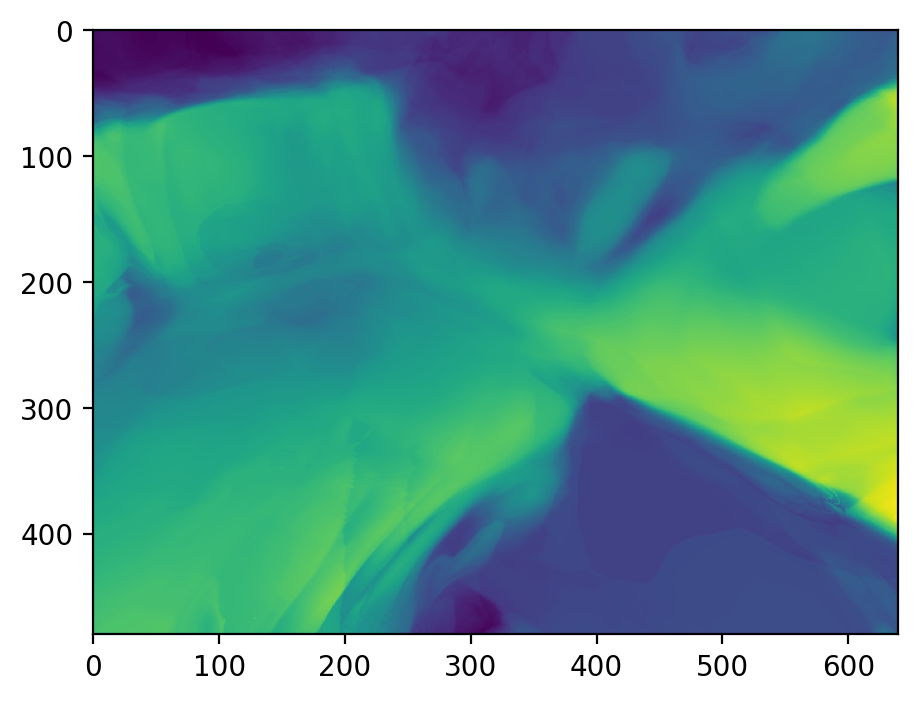

In [31]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)